In [1]:
%load_ext autoreload
%autoreload 2
import torch
import math
import os
os.chdir("../")

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
def colorize(string,color="red"):
     return f"<span style=\"color:{color}\">{string}</span>"

## Data for this script:

In [2]:
INDEPENDENT_READER_MODEL = ".checkpoints/checkpoint_squad_transformers_bert-base-uncased_independent_EM_81.47_F1_88.80.pt.sd"
CONDITIONAL_READER_MODEL = ".saved/checkpoint_squad2_transformers_bert-base-uncased_conditional_<class 'src.scripts.trainers.LRMtrainer.QAFramework'>_EM_72.82_F1_75.86_L_0.00_2021-01-24_05:19_athena19.pt"
JOINT_READER_MODEL = ".checkpoints/checkpoint_squad_transformers_bert-base-uncased_joint_EM_81.49_F1_88.25.pt.sd"
COMPOUND_READER_MODEL = ".checkpoints/checkpoint_squad_transformers_bert-base-uncased_compound_EM_82.25_F1_88.77.pt.sd"

In [3]:
import torch
from transformers import BertTokenizer
from src.scripts.trainers.LRMtrainer import QAFramework

device=torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", cache_dir=".Transformers_cache")

def load_model(m):
    model_dict=torch.load(m)
    if type(model_dict) == dict:
        model = QAFramework.create_model(model_dict["config"], device, tokenizer)
        model.load_state_dict(model_dict["state_dict"])
    else:
        model = model_dict
    return model.to(device)

In [4]:
indep_reader_model = load_model(INDEPENDENT_READER_MODEL)
joint_reader_model =load_model(JOINT_READER_MODEL)
compound_reader_model = load_model(COMPOUND_READER_MODEL)


indep_reader_model = indep_reader_model.eval()
joint_reader_model = joint_reader_model.eval()
compound_reader_model = compound_reader_model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

In [5]:
conditional_reader_model=load_model(CONDITIONAL_READER_MODEL)
# conditional model has hardcoded validation batch
conditional_reader_model.bs = 1
BEAM_SIZE=10
conditional_reader_model.topk=BEAM_SIZE
conditional_reader_model.top_k_combined = torch.empty([1, BEAM_SIZE, 384, 768 * 2])
conditional_reader_model = conditional_reader_model.eval()

# Playing around with the models

In [6]:
from src.datasets.SQUAD_dataset_transformers import SquadDataset_transformers
from src.datasets.utility import VALIDATION_F_SQUAD,TRAIN_F_SQUAD


fields = SquadDataset_transformers.prepare_fields(pad_t=tokenizer.pad_token_id)
val_data = SquadDataset_transformers(VALIDATION_F_SQUAD, tokenizer, fields, transformer='bert-base-uncased',is_training=False)
print("Val data loaded")

Val data loaded


interesting NQ example id: "988bb3170e3f43108217ba526efaf7ed "

In [7]:
fields

[('id', <torchtext.data.field.RawField at 0x7f69c1ec3630>),
 ('input', <torchtext.data.field.Field at 0x7f69c1e0a9e8>),
 ('segment_ids', <torchtext.data.field.Field at 0x7f69c1f0c550>),
 ('input_padding', <torchtext.data.field.Field at 0x7f69c1f0c518>),
 ('a_start', <torchtext.data.field.Field at 0x7f69c1f0c588>),
 ('a_end', <torchtext.data.field.Field at 0x7f69c1f0c710>),
 ('is_max_context', <torchtext.data.field.RawField at 0x7f69c1f0c780>),
 ('paragraph_mask', <torchtext.data.field.Field at 0x7f69c1f0c7b8>),
 ('example_idx', <torchtext.data.field.RawField at 0x7f69c1f0c630>),
 ('token_to_orig_map', <torchtext.data.field.RawField at 0x7f69c1f0c6a0>)]

In [8]:
i = 55
printmd(colorize(tokenizer.decode(val_data.examples[i].input),color="red"))

<span style="color:red">[CLS] who was the super bowl 50 mvp? [SEP] the broncos took an early lead in super bowl 50 and never trailed. newton was limited by denver's defense, which sacked him seven times and forced him into three turnovers, including a fumble which they recovered for a touchdown. denver linebacker von miller was named super bowl mvp, recording five solo tackles, 2½ sacks, and two forced fumbles. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]</span>

In [9]:
from src.models.utils.modelparts import SpanPredictionModule
hacks = {
            "max_answer_length": 30
        }
def get_span(example,ans):
    return tokenizer.decode(example.input[ans[0]:ans[1]+1])

In [10]:
import torch.nn.functional as F
def get_topk_answers(model, example, K=20, device=torch.device("cpu")):
    model = model.to(device)
    inp = torch.LongTensor(example.input).unsqueeze(0).to(device)
    segment_ids = torch.LongTensor(example.segment_ids).unsqueeze(0).to(device)
    input_padding = torch.LongTensor(example.input_padding).unsqueeze(0).to(device)
    


    logprobs_S, logprobs_E = model(inp, token_type_ids=segment_ids,  attention_mask=input_padding)
    mask = ~segment_ids.bool()
    logprobs_S.masked_fill_(mask, -math.inf)
    logprobs_E.masked_fill_(mask, -math.inf)
    
    sorted_span_scores, sorted_span_positions = SpanPredictionModule.decode_topN_with_hacks(
                    logprobs_S,
                    logprobs_E,
                    score="logprobs",
                    N=10_000,
                    has_sentinel=True, hacks=hacks)
    sorted_span_positions = (sorted_span_positions[0][:,:K],sorted_span_positions[1][:,:K])
    sorted_span_probs = F.softmax(sorted_span_scores,-1)[:,:K]
    confidences = sorted_span_probs.tolist()[0]
    answers = []
    # we assume only batch size 1 in this example, by picking 0th index
    for position in zip(sorted_span_positions[0].tolist()[0], sorted_span_positions[1].tolist()[0]):
        answers.append(get_span(example, position))
    return answers, confidences

In [11]:
def get_topk_answers_joint(model, example, K=20,device=torch.device("cpu")):
    inp = torch.LongTensor(example.input).unsqueeze(0).to(device)
    segment_ids = torch.LongTensor(example.segment_ids).unsqueeze(0).to(device)
    input_padding = torch.LongTensor(example.input_padding).unsqueeze(0).to(device)
    model = model.to(device)
    
    outputs= model(inp, token_type_ids=segment_ids,  attention_mask=input_padding)
    if len(outputs) == 3:
        logprobs_S, logprobs_E, logprobs_J = outputs
    else:
        logprobs_J = outputs
    
    sorted_span_scores, sorted_span_positions = SpanPredictionModule.decode_topN_joint_wth_hacks(logprobs_J,
                    score="logprobs",
                    N=10_000,
                    has_sentinel=True, hacks=hacks)
    sorted_span_positions = (sorted_span_positions[0][:,:K],sorted_span_positions[1][:,:K])
    sorted_span_probs = F.softmax(sorted_span_scores,-1)[:,:K]
    confidences = sorted_span_probs.tolist()[0]
    answers = []
    # we assume only batch size 1 in this example, by picking 0th index
    for position in zip(sorted_span_positions[0].tolist()[0], sorted_span_positions[1].tolist()[0]):
        answers.append(get_span(example, position))
    return answers, confidences

In [12]:
def get_topk_answers_conditional(model, example, K=20, device=torch.device("cpu")):
    inp = torch.LongTensor(example.input).unsqueeze(0).to(device)
    segment_ids = torch.LongTensor(example.segment_ids).unsqueeze(0).to(device)
    input_padding = torch.LongTensor(example.input_padding).unsqueeze(0).to(device)
    model = model.to(device)

    start_indexes, end_indexes, best_span_scores, logprobs_S, logprobs_E0, logprobs_Emax = model(
        inp,
        token_type_ids=segment_ids,
        attention_mask=input_padding)
    max_len = 30
    best_scores_f = []
    start_indexes_f = []
    end_indexes_f = []
    for sib, eib, ssb in zip(start_indexes, end_indexes, best_span_scores):
        scores_l = []
        end_l = []
        lens = []
        start_l = []
        for si, ei, ss in zip(sib, eib, ssb):
            lens.append(ei - si)
            if ei - si <= max_len and ei >= si:
                scores_l.append(ss)
                end_l.append(ei)
                start_l.append(si)
        best_scores_f.append(scores_l)
        start_indexes_f.append(start_l)
        end_indexes_f.append(end_l)
    # if logprobs_S.shape[0]!=logprobs_E.shape[0]:
    padded_S = torch.zeros(logprobs_E0.shape)
    padded_S[:logprobs_S.shape[0], :] = logprobs_S
    logprobs_S = padded_S

    confidences = best_scores_f[0]
    answers = []
    # we assume only batch size 1 in this example, by picking 0th index
    for position in zip(start_indexes_f[0], end_indexes_f[0]):
        answers.append(get_span(example, position))
    return answers, confidences

In [13]:
picked_id = "56d709ef0d65d21400198306" # Rivera example
#picked_id ='56bebb293aeaaa14008c9305'
# picked_id = "57060cc352bb891400689811"
# picked_id = '56f80e1daef2371900625d8d'
# # picked_id = '57263ea0271a42140099d7c3'
# picked_id = "57332b66d058e614000b5758"
# picked_id = "56bec38b3aeaaa14008c9398"
# picked_id = "5725dd1689a1e219009abfe3"
# picked_id = "5729f0db6aef051400155127"

# for NQ
#picked_id="988bb3170e3f43108217ba526efaf7ed"


for i in range(len(val_data.examples)):
    if val_data.problem_examples[val_data.examples[i].example_idx].qas_id == picked_id:
        break
        

    
printmd("<span style=\"font-size:larger;\">INDEPENDENT</span>")
printmd(colorize(tokenizer.decode(val_data.examples[i].input[:val_data.examples[i].input.index(tokenizer.sep_token_id)], skip_special_tokens=True),color="red"))
printmd(colorize(tokenizer.decode(val_data.examples[i].input[val_data.examples[i].input.index(tokenizer.sep_token_id):], skip_special_tokens=True),color="blue"))
printmd(colorize(
    [a['text'] for a in val_data.problem_examples[val_data.examples[i].example_idx].answers]
    ,color="green"))

answers, confidences = get_topk_answers(indep_reader_model,val_data.examples[i])
for i, (answer, confidence) in enumerate(zip(answers, confidences)):
   print(f"{i}. confidence:{confidence:.6f} length:{len(answer)} content:\"{answer}\".")
print("----------------------------------------------------------------------")

<span style="font-size:larger;">INDEPENDENT</span>

<span style="color:red">who was the panthers head coach for the 2015 season?</span>

<span style="color:blue">with rivera having been a linebacker with the chicago bears in super bowl xx, and kubiak replacing elway at the end of the broncos'defeats in super bowls xxi and xxiv, this will be the first super bowl in which both head coaches played in the game themselves.</span>

<span style="color:green">['Rivera', 'Rivera', 'Rivera']</span>

0. confidence:0.379399 length:83 content:"rivera having been a linebacker with the chicago bears in super bowl xx, and kubiak".
1. confidence:0.282648 length:6 content:"rivera".
2. confidence:0.202606 length:6 content:"kubiak".
3. confidence:0.070172 length:99 content:"rivera having been a linebacker with the chicago bears in super bowl xx, and kubiak replacing elway".
4. confidence:0.037473 length:22 content:"kubiak replacing elway".
5. confidence:0.003705 length:5 content:"elway".
6. confidence:0.002493 length:42 content:"chicago bears in super bowl xx, and kubiak".
7. confidence:0.001730 length:3 content:"##k".
8. confidence:0.001586 length:54 content:"rivera having been a linebacker with the chicago bears".
9. confidence:0.001440 length:72 content:"rivera having been a linebacker with the chicago bears in super bowl xx,".
10. confidence:0.001270 length:25 content:"super bowl xx, and kubiak".
11. confidence:0.001183 length:71 content:"rivera having been a linebacker with the chicago

In [14]:
for i in range(len(val_data.examples)):
    if val_data.problem_examples[val_data.examples[i].example_idx].qas_id == picked_id:
        break
        

printmd("<span style=\"font-size:larger;\">JOINT</span>")
printmd(colorize(tokenizer.decode(val_data.examples[i].input[:val_data.examples[i].input.index(tokenizer.sep_token_id)], skip_special_tokens=True),color="red"))
printmd(colorize(tokenizer.decode(val_data.examples[i].input[val_data.examples[i].input.index(tokenizer.sep_token_id):], skip_special_tokens=True),color="blue"))
printmd(colorize(
    [a['text'] for a in val_data.problem_examples[val_data.examples[i].example_idx].answers]
    ,color="green"))
answers, confidences = get_topk_answers_joint(joint_reader_model,val_data.examples[i])
for i, (answer, confidence) in enumerate(zip(answers, confidences)):
    print(f"{i}. confidence:{confidence:.6f} length:{len(answer)} content:\"{answer}\".")
print("----------------------------------------------------------------------")

<span style="font-size:larger;">JOINT</span>

<span style="color:red">who was the panthers head coach for the 2015 season?</span>

<span style="color:blue">with rivera having been a linebacker with the chicago bears in super bowl xx, and kubiak replacing elway at the end of the broncos'defeats in super bowls xxi and xxiv, this will be the first super bowl in which both head coaches played in the game themselves.</span>

<span style="color:green">['Rivera', 'Rivera', 'Rivera']</span>

0. confidence:0.487464 length:6 content:"kubiak".
1. confidence:0.276969 length:22 content:"kubiak replacing elway".
2. confidence:0.127231 length:6 content:"rivera".
3. confidence:0.062721 length:5 content:"elway".
4. confidence:0.006415 length:13 content:"chicago bears".
5. confidence:0.006251 length:83 content:"rivera having been a linebacker with the chicago bears in super bowl xx, and kubiak".
6. confidence:0.003033 length:54 content:"rivera having been a linebacker with the chicago bears".
7. confidence:0.002495 length:99 content:"rivera having been a linebacker with the chicago bears in super bowl xx, and kubiak replacing elway".
8. confidence:0.001980 length:30 content:"chicago bears in super bowl xx".
9. confidence:0.001926 length:48 content:"kubiak replacing elway at the end of the broncos".
10. confidence:0.001784 length:84 content:"kubiak replacing elway at the end of the broncos'defeats in super bowls xxi and xxiv".
11. confidence:0.001714 length:75 content:"kubiak replaci

In [15]:
for i in range(len(val_data.examples)):
    if val_data.problem_examples[val_data.examples[i].example_idx].qas_id == picked_id:
        break
        

printmd("<span style=\"font-size:larger;\">COMPOUND</span>")
printmd(colorize(tokenizer.decode(val_data.examples[i].input[:val_data.examples[i].input.index(tokenizer.sep_token_id)], skip_special_tokens=True),color="red"))
printmd(colorize(tokenizer.decode(val_data.examples[i].input[val_data.examples[i].input.index(tokenizer.sep_token_id):], skip_special_tokens=True),color="blue"))
printmd(colorize(
    [a['text'] for a in val_data.problem_examples[val_data.examples[i].example_idx].answers]
    ,color="green"))
answers, confidences = get_topk_answers_joint(compound_reader_model,val_data.examples[i])
for i, (answer, confidence) in enumerate(zip(answers, confidences)):
    print(f"{i}. confidence:{confidence:.6f} length:{len(answer)} content:\"{answer}\".")
print("----------------------------------------------------------------------")

<span style="font-size:larger;">COMPOUND</span>

<span style="color:red">who was the panthers head coach for the 2015 season?</span>

<span style="color:blue">with rivera having been a linebacker with the chicago bears in super bowl xx, and kubiak replacing elway at the end of the broncos'defeats in super bowls xxi and xxiv, this will be the first super bowl in which both head coaches played in the game themselves.</span>

<span style="color:green">['Rivera', 'Rivera', 'Rivera']</span>

0. confidence:0.359451 length:6 content:"kubiak".
1. confidence:0.332965 length:6 content:"rivera".
2. confidence:0.190620 length:22 content:"kubiak replacing elway".
3. confidence:0.033865 length:5 content:"elway".
4. confidence:0.014535 length:13 content:"chicago bears".
5. confidence:0.011419 length:54 content:"rivera having been a linebacker with the chicago bears".
6. confidence:0.005700 length:83 content:"rivera having been a linebacker with the chicago bears in super bowl xx, and kubiak".
7. confidence:0.005299 length:30 content:"chicago bears in super bowl xx".
8. confidence:0.003992 length:71 content:"rivera having been a linebacker with the chicago bears in super bowl xx".
9. confidence:0.003616 length:42 content:"chicago bears in super bowl xx, and kubiak".
10. confidence:0.002995 length:99 content:"rivera having been a linebacker with the chicago bears in super bowl xx, and kubiak replacing elway".
11. confidence:0.002768 length:31 content:"chicago bears in super bowl xx,".

In [16]:
for i in range(len(val_data.examples)):
    if val_data.problem_examples[val_data.examples[i].example_idx].qas_id == picked_id:
        break
        

printmd("<span style=\"font-size:larger;\">CONDITIONAL</span>")
printmd(colorize(tokenizer.decode(val_data.examples[i].input[:val_data.examples[i].input.index(tokenizer.sep_token_id)], skip_special_tokens=True),color="red"))
printmd(colorize(tokenizer.decode(val_data.examples[i].input[val_data.examples[i].input.index(tokenizer.sep_token_id):], skip_special_tokens=True),color="blue"))
printmd(colorize(
    [a['text'] for a in val_data.problem_examples[val_data.examples[i].example_idx].answers]
    ,color="green"))
answers, confidences = get_topk_answers_conditional(conditional_reader_model,val_data.examples[i])
for i, (answer, confidence) in enumerate(zip(answers, confidences)):
    if i==20:
        break
    print(f"{i}. confidence:{confidence:.6f} length:{len(answer)} content:\"{answer}\".")
print("----------------------------------------------------------------------")

<span style="font-size:larger;">CONDITIONAL</span>

<span style="color:red">who was the panthers head coach for the 2015 season?</span>

<span style="color:blue">with rivera having been a linebacker with the chicago bears in super bowl xx, and kubiak replacing elway at the end of the broncos'defeats in super bowls xxi and xxiv, this will be the first super bowl in which both head coaches played in the game themselves.</span>

<span style="color:green">['Rivera', 'Rivera', 'Rivera']</span>

0. confidence:0.161865 length:6 content:"rivera".
1. confidence:0.161865 length:125 content:"rivera having been a linebacker with the chicago bears in super bowl xx, and kubiak replacing elway at the end of the broncos".
2. confidence:0.161865 length:99 content:"rivera having been a linebacker with the chicago bears in super bowl xx, and kubiak replacing elway".
3. confidence:0.161865 length:83 content:"rivera having been a linebacker with the chicago bears in super bowl xx, and kubiak".
4. confidence:0.161865 length:54 content:"rivera having been a linebacker with the chicago bears".
5. confidence:0.161865 length:79 content:"rivera having been a linebacker with the chicago bears in super bowl xx, and ku".
6. confidence:0.161865 length:96 content:"rivera having been a linebacker with the chicago bears in super bowl xx, and kubiak replacing el".
7. confidence:0.092605 length:5 content:"elway".
8. confidence:0.092605 length:67 content:"elway at the end of the broncos'defeats in super bow

# Analysing model differences

In [15]:
import json
indep_preds = json.load(open("results_diff/squad1.1/bert_dev_results_indep.json"))
compound_preds = json.load(open("results_diff/squad1.1/bert_dev_results_compound.json"))

In [16]:
diff = { k : (indep_preds[k],compound_preds[k]) for k in compound_preds.keys() if indep_preds[k] != compound_preds[k]}
len(diff)

1937

### Good example for surface form normalization
'56bec38b3aeaaa14008c9398': ('Death Wish Coffee had a 30-second commercial aired free of charge courtesy of QuickBooks. Death Wish Coffee',
  'Death Wish Coffee'),

### Good example for compound loss improvement
'56d709ef0d65d21400198306': ('Rivera having been a linebacker with the Chicago Bears in Super Bowl XX, and Kubiak replacing Elway',
  'Rivera'),

In [19]:
indep_lengths = list(map(len, list(indep_preds.values())))

In [20]:
compound_lengths = list(map(len, list(compound_preds.values())))

In [21]:
print(f"Indep avg: {sum(indep_lengths)/len(indep_lengths)}")
print(f"Joint avg: {sum(compound_lengths)/len(compound_lengths)}")

Indep avg: 19.754399243140966
Joint avg: 18.356385998107854


The joint predictions from compound model seem to be slighly shorter

### Predicted answer length distribution

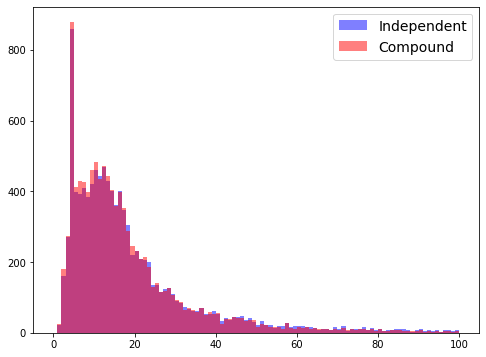

In [22]:
import matplotlib.pyplot as plt

values1 = indep_lengths
values2= compound_lengths
bins=100
domain_range=(0,100)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111) 
ax.hist(values1, alpha=0.5, bins=bins, range=domain_range, color= 'b', label='Independent')
ax.hist(values2, alpha=0.5, bins=bins, range=domain_range, color= 'r', label='Compound')
ax.legend(loc='upper right', prop={'size':14})
plt.show()

In the best prediction setting, the predictions seem to have similar lengths. Lets try to look at what happens, if we (artificially) make a model a little bit more uncertain.

# Comparing Top-K answer length distributions

In [17]:
import json
dataset = ".data/squad/dev-v1.1.json"
with open(dataset, encoding="utf-8") as f:
    data= json.load(f)['data']

gt_average_lengths=[]
for data_topic in data:
    topic_title = data_topic["title"]
    for paragraph in data_topic["paragraphs"]:
        for question_and_answers in paragraph['qas']:
            gt_ans_lens = [len(a["text"]) for a in question_and_answers["answers"]]
            gt_average_lengths.append(sum(gt_ans_lens)/len(gt_ans_lens))
            

In [18]:
from tqdm import tqdm
@torch.no_grad()
def get_topK_lens_probs(model, topk_callback, K=100):
    topK_lengths = []
    topK_probs=[]
    device = torch.device("cuda:0")
    model = model.to(device)
    for idx,example in enumerate(tqdm(val_data.examples)):
        answers, confidences = topk_callback(model,example, device=device,K=K)
        a_lengths = list(map(len, answers))
        topK_lengths.append(a_lengths)
        topK_probs.append(confidences)
    return topK_lengths, topK_probs

In [19]:
cond_topK_lengths,cond_topK_probs= get_topK_lens_probs(conditional_reader_model, get_topk_answers_conditional)

100%|██████████| 10833/10833 [1:03:04<00:00,  2.86it/s]


In [20]:
indep_topK_lengths,indep_topK_probs= get_topK_lens_probs(indep_reader_model, get_topk_answers)

100%|██████████| 10833/10833 [05:40<00:00, 31.84it/s]


In [22]:
joint_topK_lengths,joint_topK_probs= get_topK_lens_probs(joint_reader_model, get_topk_answers_joint)

100%|██████████| 10833/10833 [05:40<00:00, 31.83it/s]


In [23]:
compound_topK_lengths,compound_topK_probs= get_topK_lens_probs(compound_reader_model, get_topk_answers_joint)

100%|██████████| 10833/10833 [05:40<00:00, 31.84it/s]


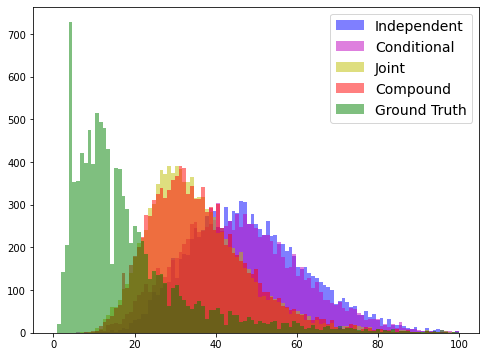

In [24]:
import matplotlib.pyplot as plt

K=20
indep_topK_averagelengths = [sum(x[:K])/len(x[:K]) for x in indep_topK_lengths]
joint_topK_averagelengths = [sum(x[:K])/len(x[:K]) for x in joint_topK_lengths]
compound_topK_averagelengths = [sum(x[:K])/len(x[:K]) for x in compound_topK_lengths]
conditional_topK_averagelengths = [sum(x[:K])/len(x[:K]) for x in cond_topK_lengths]


bins=107
_range=(0,100)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111) 
ax.hist(indep_topK_averagelengths, alpha=0.5, bins=bins, range=_range, color= 'b', label='Independent')
ax.hist(conditional_topK_averagelengths, alpha=0.5, bins=bins, range=_range, color= 'm', label='Conditional')
ax.hist(joint_topK_averagelengths, alpha=0.5, bins=bins, range=_range, color= 'y', label='Joint')
ax.hist(compound_topK_averagelengths, alpha=0.5, bins=bins, range=_range, color= 'r', label='Compound')
ax.hist(gt_average_lengths, alpha=0.5, bins=bins, range=_range, color= 'g', label='Ground Truth')
ax.legend(loc='upper right', prop={'size':14})
plt.show()

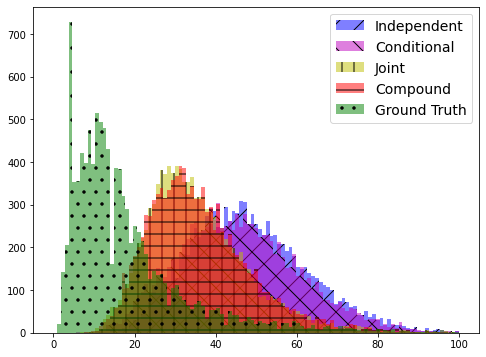

In [25]:
# Hatched version
bins = 107
_range=(0,100)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111) 
ax.hist(indep_topK_averagelengths, alpha=0.5, bins=bins, range=_range, color= 'b', hatch='/',label='Independent')
ax.hist(conditional_topK_averagelengths, alpha=0.5, bins=bins, range=_range, color= 'm', hatch='\\',label='Conditional')
ax.hist(joint_topK_averagelengths, alpha=0.5, bins=bins, range=_range, color= 'y', hatch='|',label='Joint')
ax.hist(compound_topK_averagelengths, alpha=0.5, bins=bins, range=_range, color= 'r', hatch='-',label='Compound')
ax.hist(gt_average_lengths, alpha=0.5, bins=bins, range=_range, color= 'g', hatch='.',label='Ground Truth')
ax.legend(loc='upper right', prop={'size':14})
plt.show()

We have took the lengths of top-K answer spans, instead of just top-1 to capture the effect of uncertain prediction -- the model is "forced to be uncertain" a about the n-bth best prediction (n>1). We see independent model in this scenarions picks longer spans than the joint objectives.

In [26]:
import itertools
from collections import OrderedDict
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cycler import cycler
from six.moves import zip


def filled_hist(ax, edges, values, bottoms=None, orientation='v',
                **kwargs):
    """
    Draw a histogram as a stepped patch.

    Extra kwargs are passed through to `fill_between`

    Parameters
    ----------
    ax : Axes
        The axes to plot to

    edges : array
        A length n+1 array giving the left edges of each bin and the
        right edge of the last bin.

    values : array
        A length n array of bin counts or values

    bottoms : scalar or array, optional
        A length n array of the bottom of the bars.  If None, zero is used.

    orientation : {'v', 'h'}
       Orientation of the histogram.  'v' (default) has
       the bars increasing in the positive y-direction.

    Returns
    -------
    ret : PolyCollection
        Artist added to the Axes
    """
    print(orientation)
    if orientation not in set('hv'):
        raise ValueError("orientation must be in {{'h', 'v'}} "
                         "not {o}".format(o=orientation))

    kwargs.setdefault('step', 'post')
    edges = np.asarray(edges)
    values = np.asarray(values)
    if len(edges) - 1 != len(values):
        raise ValueError('Must provide one more bin edge than value not: '
                         'len(edges): {lb} len(values): {lv}'.format(
                             lb=len(edges), lv=len(values)))

    if bottoms is None:
        bottoms = np.zeros_like(values)
    if np.isscalar(bottoms):
        bottoms = np.ones_like(values) * bottoms

    values = np.r_[values, values[-1]]
    bottoms = np.r_[bottoms, bottoms[-1]]
    if orientation == 'h':
        return ax.fill_betweenx(edges, values, bottoms,
                                **kwargs)
    elif orientation == 'v':
        return ax.fill_between(edges, values, bottoms,
                               **kwargs)
    else:
        raise AssertionError("you should never be here")


def stack_hist(ax, stacked_data, sty_cycle, bottoms=None,
               hist_func=None, labels=None,
               plot_func=None, plot_kwargs=None):
    """
    ax : axes.Axes
        The axes to add artists too

    stacked_data : array or Mapping
        A (N, M) shaped array.  The first dimension will be iterated over to
        compute histograms row-wise

    sty_cycle : Cycler or operable of dict
        Style to apply to each set

    bottoms : array, optional
        The initial positions of the bottoms, defaults to 0

    hist_func : callable, optional
        Must have signature `bin_vals, bin_edges = f(data)`.
        `bin_edges` expected to be one longer than `bin_vals`

    labels : list of str, optional
        The label for each set.

        If not given and stacked data is an array defaults to 'default set {n}'

        If stacked_data is a mapping, and labels is None, default to the keys
        (which may come out in a random order).

        If stacked_data is a mapping and labels is given then only
        the columns listed by be plotted.

    plot_func : callable, optional
        Function to call to draw the histogram must have signature:

          ret = plot_func(ax, edges, top, bottoms=bottoms,
                          label=label, **kwargs)

    plot_kwargs : dict, optional
        Any extra kwargs to pass through to the plotting function.  This
        will be the same for all calls to the plotting function and will
        over-ride the values in cycle.

    Returns
    -------
    arts : dict
        Dictionary of artists keyed on their labels
    """
    # deal with default binning function
    if hist_func is None:
        hist_func = np.histogram

    # deal with default plotting function
    if plot_func is None:
        plot_func = filled_hist

    # deal with default
    if plot_kwargs is None:
        plot_kwargs = {}
    print(plot_kwargs)
    try:
        l_keys = stacked_data.keys()
        label_data = True
        if labels is None:
            labels = l_keys

    except AttributeError:
        label_data = False
        if labels is None:
            labels = itertools.repeat(None)

    if label_data:
        loop_iter = enumerate((stacked_data[lab], lab, s) for lab, s in
                              zip(labels, sty_cycle))
    else:
        loop_iter = enumerate(zip(stacked_data, labels, sty_cycle))

    arts = {}
    for j, (data, label, sty) in loop_iter:
        if label is None:
            label = 'dflt set {n}'.format(n=j)
        label = sty.pop('label', label)
        vals, edges = hist_func(data)
        if bottoms is None:
            bottoms = np.zeros_like(vals)
        top = bottoms + vals
        print(sty)
        sty.update(plot_kwargs)
        print(sty)
        ret = plot_func(ax, edges, top, bottoms=bottoms,
                        label=label, **sty)
        bottoms = top
        arts[label] = ret
    ax.legend(fontsize=10)
    return arts



{}
{'facecolor': 'b', 'hatch': '/'}
{'facecolor': 'b', 'hatch': '/'}
v
{'facecolor': 'm', 'hatch': '\\'}
{'facecolor': 'm', 'hatch': '\\'}
v
{'facecolor': 'y', 'hatch': '|'}
{'facecolor': 'y', 'hatch': '|'}
v
{'facecolor': 'r', 'hatch': '-'}
{'facecolor': 'r', 'hatch': '-'}
v
{'facecolor': 'g', 'hatch': '.'}
{'facecolor': 'g', 'hatch': '.'}
v


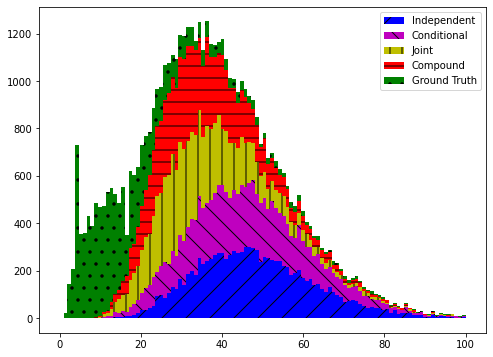

In [27]:
# set up histogram function to fixed bins
edges = np.linspace(0, 100, 107, endpoint=True)
hist_func = partial(np.histogram, bins=edges)

# set up style cycles
color_cycle = cycler(facecolor=['b','m','y','r','g']) #plt.rcParams['axes.prop_cycle'][:3]
label_cycle = cycler(label=['Independent', 'Conditional', 'Joint','Compound','Ground Truth' ])
hatch_cycle = cycler(hatch=['/','\\','|', '-', '.' ])


 
stack_data = [indep_topK_averagelengths, conditional_topK_averagelengths, joint_topK_averagelengths,compound_topK_averagelengths, gt_average_lengths]
dict_data = OrderedDict(zip((c['label'] for c in label_cycle), stack_data))

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111) 
arts = stack_hist(ax, stack_data, color_cycle + label_cycle + hatch_cycle,
                  hist_func=hist_func)

## Lets try to compare uncertain predictions!


In [39]:
len(val_data),len(indep_topK_lengths),len(joint_topK_lengths),len(compound_topK_lengths), len(indep_topK_probs)

(10833, 10833, 10833, 10833, 10833)

We use simple threshold on most probable answer. If the  top-answer probability is lesser than threshold, we assume the answer is "uncertain" and include it in the histogram.

In [40]:
filtered_indep_topK_lens = [lens[0] for lens, probs in zip(indep_topK_lengths,indep_topK_probs) if probs[0]<0.2]
filtered_joint_topK_lens = [lens[0] for lens, probs in zip(joint_topK_lengths,joint_topK_probs) if probs[0]<0.2]
filtered_compound_topK_lens = [lens[0] for lens, probs in zip(compound_topK_lengths,compound_topK_probs) if probs[0]<0.2]
len(filtered_indep_topK_lens),len(filtered_joint_topK_lens),len(filtered_compound_topK_lens),len(filtered_conditional_topK_lens)

(373, 248, 286, 357)

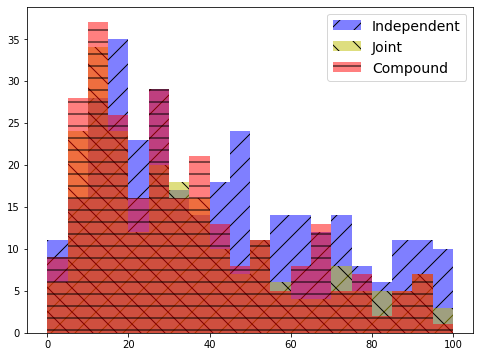

In [41]:
bins = 20
_range=(0,100)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111) 
ax.hist(filtered_indep_topK_lens, alpha=0.5, bins=bins, range=_range, color= 'b', hatch='/',label='Independent')
ax.hist(filtered_joint_topK_lens, alpha=0.5, bins=bins, range=_range, color= 'y', hatch='\\',label='Joint')
ax.hist(filtered_compound_topK_lens, alpha=0.5, bins=bins, range=_range, color= 'r', hatch='-',label='Compound')
#ax.hist(gt_average_lengths, alpha=0.5, bins=bins, range=_range, color= 'g', hatch='|',label='Ground Truth')
ax.legend(loc='upper right', prop={'size':14})
plt.show()

The graph again shows the independent objective "lags" behind other objectives in the (top) prediction length